In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 8 - Comparing Gaussian means
## 8.1 One-sample comparison


$$ \delta \sim \text{Cauchy} (0, 1)$$
$$ \sigma \sim \text{Cauchy} (0, 1)_{\mathcal I(0,∞)}$$
$$ \mu = \delta\sigma $$
$$ x_{i} \sim \text{Gaussian}(\mu,1/\sigma^2)$$

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -62.754: 100%|██████████| 200000/200000 [00:09<00:00, 20313.64it/s]
Finished [100%]: Average ELBO = -62.753
100%|██████████| 3000/3000.0 [00:02<00:00, 1424.02it/s]


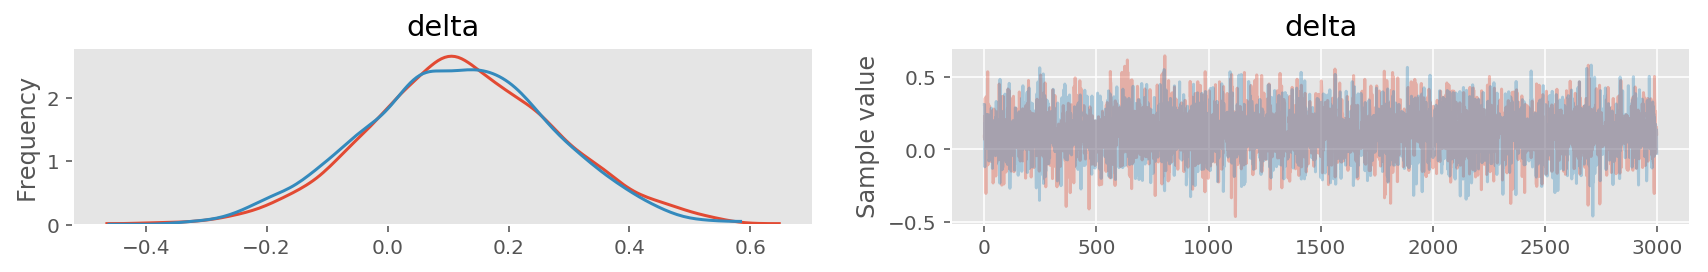

In [2]:
# Read data Dr. Smith
Winter = np.array([-0.05,0.41,0.17,-0.13,0.00,-0.05,0.00,0.17,0.29,0.04,0.21,0.08,0.37,
            0.17,0.08,-0.04,-0.04,0.04,-0.13,-0.12,0.04,0.21,0.17,0.17,0.17,
            0.33,0.04,0.04,0.04,0.00,0.21,0.13,0.25,-0.05,0.29,0.42,-0.05,0.12,
            0.04,0.25,0.12])

Summer = np.array([0.00,0.38,-0.12,0.12,0.25,0.12,0.13,0.37,0.00,0.50,0.00,0.00,-0.13,
            -0.37,-0.25,-0.12,0.50,0.25,0.13,0.25,0.25,0.38,0.25,0.12,0.00,0.00,
            0.00,0.00,0.25,0.13,-0.25,-0.38,-0.13,-0.25,0.00,0.00,-0.12,0.25,
            0.00,0.50,0.00])
x = Winter - Summer  # allowed because it is a within-subjects design
x = x / np.std(x)  

with pm.Model() as model1:
    delta = pm.Cauchy('delta', alpha=0, beta=1)
    sigma = pm.HalfCauchy('sigma', beta=1)
    miu = delta*sigma
    xi = pm.Normal('xi', mu=miu, sd=sigma, observed=x)
    trace1=pm.sample(3e3, njobs=2)

burnin=0    
pm.traceplot(trace1[burnin:], varnames=['delta']);
plt.show()

In [3]:
def display_delta(trace, x):
    # BFs based on density estimation (using kernel smoothing instead of spline)
    from scipy.stats.kde import gaussian_kde
    from scipy.stats import cauchy

    pm.summary(trace, varnames=['delta'])
    tmp = pm.df_summary(trace, varnames=['delta'])
    # 95% confidence interval:
    x0 = tmp.values[0, 3]
    x1 = tmp.values[0, 4]

    t_delt = trace['delta'][:]
    my_pdf = gaussian_kde(t_delt)
    plt.plot(x, my_pdf(x), '--', lw=2.5, alpha=0.6, label='Posterior') # distribution function
    plt.plot(x, cauchy.pdf(x), 'r-', lw=2.5, alpha=0.6, label='Prior')
    posterior = my_pdf(0)             # this gives the pdf at point delta = 0
    prior     = cauchy.pdf(0)         # height of order-restricted prior at delta = 0
    BF01      = posterior/prior
    print ('the Bayes Factor is %.5f' %(BF01))
    plt.plot([0, 0], [posterior, prior], 'k-', 
             [0, 0], [posterior, prior], 'ko', lw=1.5, alpha=1)
    plt.xlabel('Delta')
    plt.ylabel('Density')
    plt.legend(loc='upper left')
    plt.show()


delta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.118            0.156            0.002            [-0.201, 0.412]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.190         0.016          0.116          0.223          0.428

the Bayes Factor is 5.83564


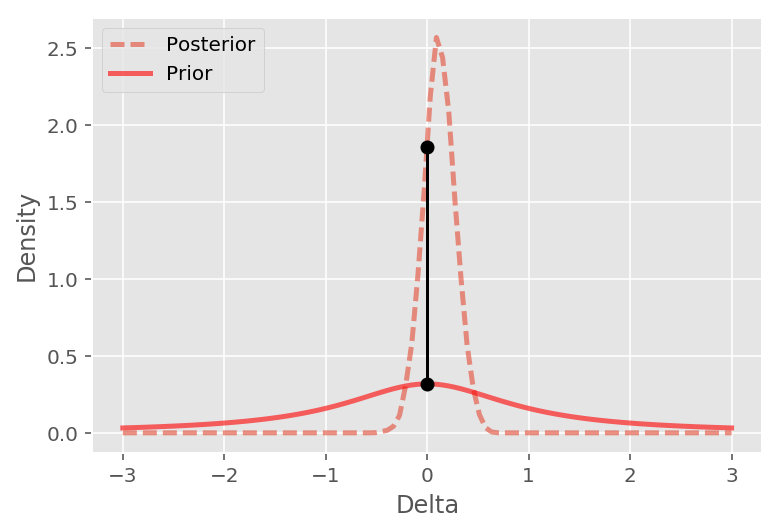

In [4]:
x = np.linspace(-3, 3, 100)
display_delta(trace1, x)

## 8.2 Order-restricted one-sample comparison


$$ \delta \sim \text{Cauchy} (0, 1)_{\mathcal I(-∞,0)}$$
$$ \sigma \sim \text{Cauchy} (0, 1)_{\mathcal I(0,∞)}$$
$$ \mu = \delta\sigma $$
$$ x_{i} \sim \text{Gaussian}(\mu,1/\sigma^2)$$

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -64.116: 100%|██████████| 200000/200000 [00:10<00:00, 19737.04it/s]
Finished [100%]: Average ELBO = -64.151
100%|██████████| 3000/3000.0 [00:02<00:00, 1084.44it/s]


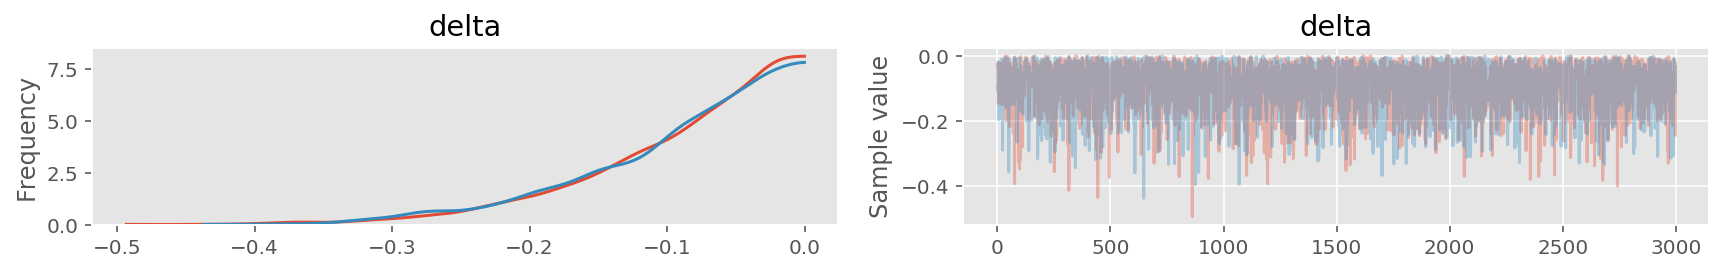

In [5]:
# Read data Dr. Smith
Winter = np.array([-0.05,0.41,0.17,-0.13,0.00,-0.05,0.00,0.17,0.29,0.04,0.21,0.08,0.37,
            0.17,0.08,-0.04,-0.04,0.04,-0.13,-0.12,0.04,0.21,0.17,0.17,0.17,
            0.33,0.04,0.04,0.04,0.00,0.21,0.13,0.25,-0.05,0.29,0.42,-0.05,0.12,
            0.04,0.25,0.12])

Summer = np.array([0.00,0.38,-0.12,0.12,0.25,0.12,0.13,0.37,0.00,0.50,0.00,0.00,-0.13,
            -0.37,-0.25,-0.12,0.50,0.25,0.13,0.25,0.25,0.38,0.25,0.12,0.00,0.00,
            0.00,0.00,0.25,0.13,-0.25,-0.38,-0.13,-0.25,0.00,0.00,-0.12,0.25,
            0.00,0.50,0.00])
x = Winter - Summer  # allowed because it is a within-subjects design
x = x / np.std(x)  

with pm.Model() as model2:
    delta1 = pm.HalfCauchy('delta1', beta=1)
    delta = pm.Deterministic('delta', -delta1)
    sigma = pm.HalfCauchy('sigma', beta=1)
    miu = delta*sigma
    xi = pm.Normal('xi', mu=miu, sd=sigma, observed=x)
    trace2=pm.sample(3e3, njobs=2)

burnin=0
pm.traceplot(trace2[burnin:], varnames=['delta']);
plt.show()


delta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.089           0.073            0.001            [-0.237, -0.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.276         -0.129         -0.070         -0.031         -0.003

the Bayes Factor is 12.58035


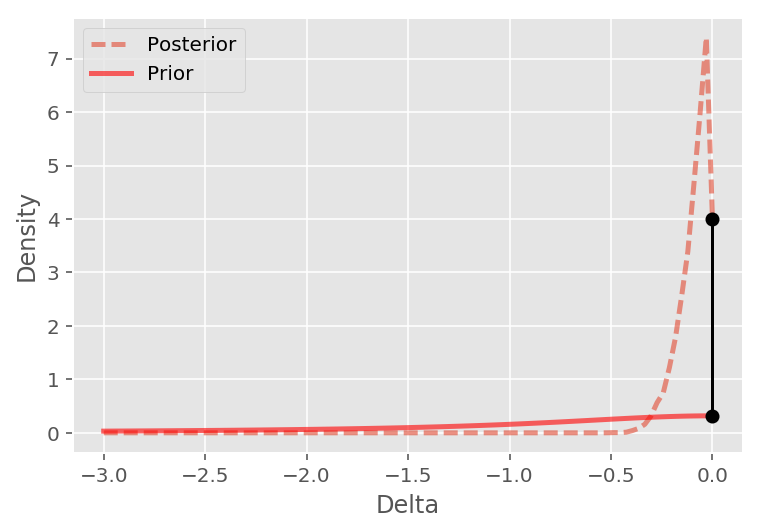

In [6]:
x = np.linspace(-3, 0, 100)
display_delta(trace2, x)

## 8.3 Two-sample comparison


$$ \delta \sim \text{Cauchy} (0, 1)$$
$$ \mu \sim \text{Cauchy} (0, 1)$$
$$ \sigma \sim \text{Cauchy} (0, 1)_{\mathcal I(0,∞)}$$
$$ \alpha = \delta\sigma $$
$$ x_{i} \sim \text{Gaussian}(\mu+\frac{\alpha}{2},1/\sigma^2)$$
$$ y_{i} \sim \text{Gaussian}(\mu-\frac{\alpha}{2},1/\sigma^2)$$


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -73.87: 100%|██████████| 200000/200000 [00:12<00:00, 16654.25it/s] 
Finished [100%]: Average ELBO = -73.855
100%|██████████| 3000/3000.0 [00:02<00:00, 1031.64it/s]


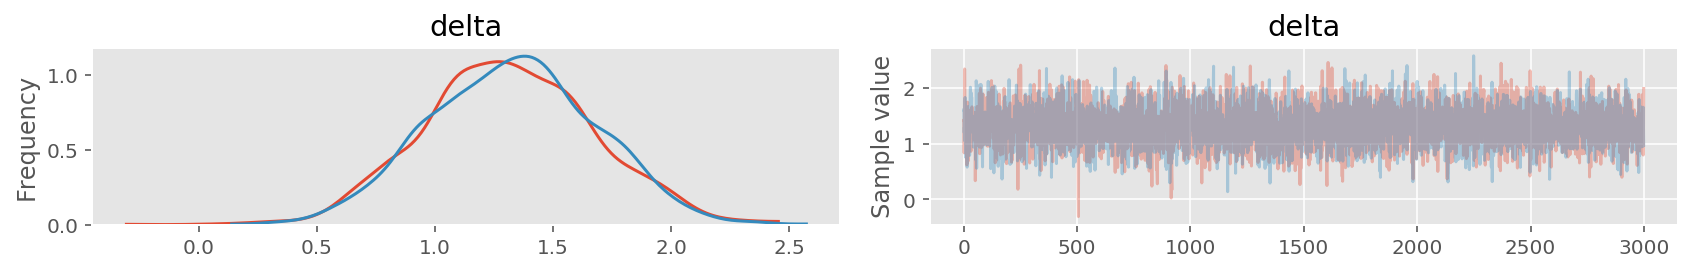

In [7]:
# Read data 
x =np.array([70,80,79,83,77,75,84,78,75,75,78,82,74,81,72,70,75,72,76,77])
y =np.array([56,80,63,62,67,71,68,76,79,67,76,74,67,70,62,65,72,72,69,71])

n1 = len(x)
n2 = len(y)

# Rescale
y = y - np.mean(x)
y = y / np.std(x)
x = (x - np.mean(x)) / np.std(x)

with pm.Model() as model3:
    delta = pm.Cauchy('delta', alpha=0, beta=1)
    mu = pm.Cauchy('mu', alpha=0, beta=1)
    sigma = pm.HalfCauchy('sigma', beta=1)
    alpha = delta*sigma
    xi = pm.Normal('xi', mu=mu+alpha/2, sd=sigma, observed=x)
    yi = pm.Normal('yi', mu=mu-alpha/2, sd=sigma, observed=y)
    trace3=pm.sample(3e3, njobs=2)

burnin=0    
pm.traceplot(trace3[burnin:], varnames=['delta']);
plt.show()


delta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.317            0.353            0.005            [0.642, 1.995]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.647          1.075          1.313          1.553          2.006

the Bayes Factor is 0.00400


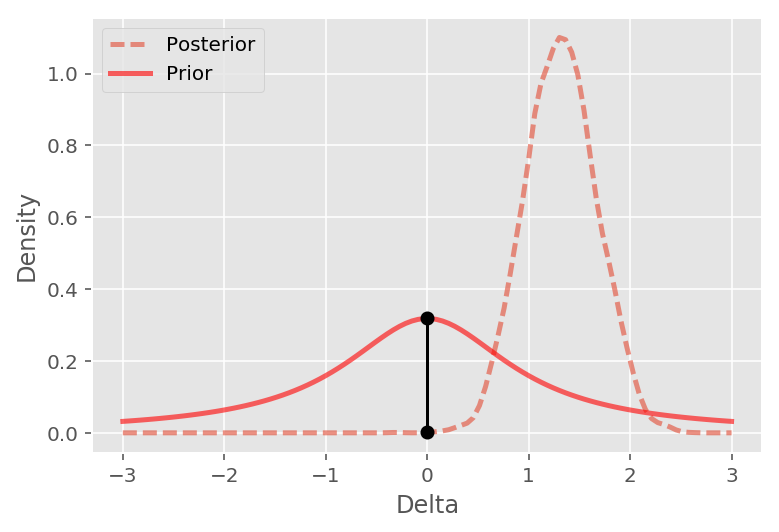

In [8]:
x = np.linspace(-3, 3, 100)
display_delta(trace3, x)